## Multi-Class Image Classification

We've just been through a bunch of the following steps with a binary classification problem. Now, we're goining o step thing up a notch with 10 classes of food.

1. Become one with the data
2. Preprocess the data (get it ready for a model)
3. Create a model (start with a baseline)
4. Fit the model (overfit it to make sure it works)
5. Evaluate the model
6. Adjust different hyperparameters and improve the model (try to beat baseline/reduce overfitting)
7. Reduce until satisfied

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import os

In [2]:
## 1. Import the data

#Wlak through 10 classes of food image data
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_all_data
There are 10 directories and 0 images in 10_food_classes_all_data/test
There are 0 directories and 250 images in 10_food_classes_all_data/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_all_data/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_all_data/test/steak
There are 0 directories and 250 images in 10_food_classes_all_data/test/sushi
There are 0 directories and 250 images in 10_food_classes_all_data/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_all_data/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_all_data/test/hamburger
There are 0 directories and 250 images in 10_food_classes_all_data/test/pizza
There are 0 directories and 250 images in 10_food_classes_all_data/test/ramen
There are 0 directories and 250 images in 10_food_classes_all_data/test/fried_rice
There are 10 directories and 0 images in 10_fo

In [3]:
# Set up train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [4]:
# Let's get the class names
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [42]:
# Create a function to import an image and resize it is able to be used with our model
def load_and_prep_image(filename, img_shape=224):
    """
    Reads image from file name.
    Turns it into tensor.
    Reshape it to img_shape.
    """

    # Read in image
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor
    img = tf.image.decode_jpeg(img)

    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    
    # Rescale the image
    img = img/255.

    return img

In [50]:
def pred_and_plot(model, filename, calss_names_test):
    """
    Import our image located at file name.
    Prediction with model.
    Match the class name.
    """
    # Load the image and pre-process
    img = load_and_prep_image(filename, img_shape=224)

    # Make the prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Add in logic for multi-class
    if len(pred[0]) > 1:
        pred_class = class_names[tf.argmax(pred[0])]
    else:
        pred_class = calss_names_test[int(tf.round(pred[0]))]    

    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.title(f"Prediction:{pred_class}")
    plt.axis(False);
    


In [12]:
# Plot the validation and training curve separately
def plot_loss (history):
    """
    returns separate loss curves and validation curves
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"])) # How many epochs did we run for

    # Plot loss
    plt.figure(figsize=(10, 7))
    plt.plot(epochs, loss, label="training loss")
    plt.plot(epochs, val_loss, label="val loss")
    plt.title("Losss")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.legend()

    # Plot accuracy
    plt.figure(figsize=(10, 7))
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="val accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    

In [5]:
# Let's visualize our images

def view_random_image(target_dir, target_class):
    # Set the target directory
    target_floder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_floder), 1)

    # Read in the image and plot it
    img = mpimg.imread(target_floder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}")

    return img


Image shape: (512, 512, 3)


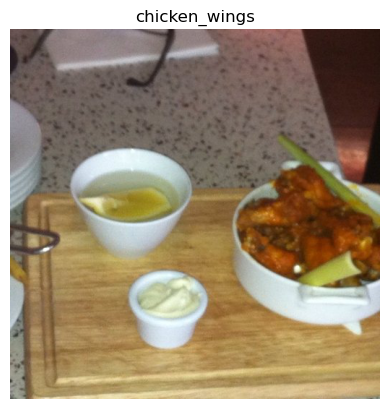

In [6]:
# Visualize
img = view_random_image(train_dir, random.choice(class_names))

### 2.  Preprocess the data (prepare it for a model) 🌏

In [8]:
# Rescale the images
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(224, 224))

test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size=(224, 224))

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 3. Create a CNN model (start with a baseline) 🧾

In [11]:
# Set seed
tf.random.set_seed(42)

# Build a model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax") # 10 outputs. Hence, we use 10 here instead.
])

# Compile a model
model_1.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"]
)

# Fit the model
history_1 = model_1.fit(train_data,
                        steps_per_epoch=len(train_data),
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5


2024-02-01 22:16:21.829538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


235/235 [==============================] - ETA: 0s - loss: 2.1111 - accuracy: 0.2260

2024-02-01 22:16:46.349546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


235/235 [==============================] - 30s 126ms/step - loss: 2.1111 - accuracy: 0.2260 - val_loss: 1.9262 - val_accuracy: 0.3144
Epoch 2/5
235/235 [==============================] - 30s 127ms/step - loss: 1.8775 - accuracy: 0.3555 - val_loss: 1.8424 - val_accuracy: 0.3556
Epoch 3/5
235/235 [==============================] - 30s 128ms/step - loss: 1.6963 - accuracy: 0.4292 - val_loss: 1.7957 - val_accuracy: 0.3844
Epoch 4/5
235/235 [==============================] - 30s 129ms/step - loss: 1.4959 - accuracy: 0.5015 - val_loss: 1.8944 - val_accuracy: 0.3500
Epoch 5/5
235/235 [==============================] - 31s 130ms/step - loss: 1.2818 - accuracy: 0.5788 - val_loss: 1.9314 - val_accuracy: 0.3648


### 5. Evaluate the model

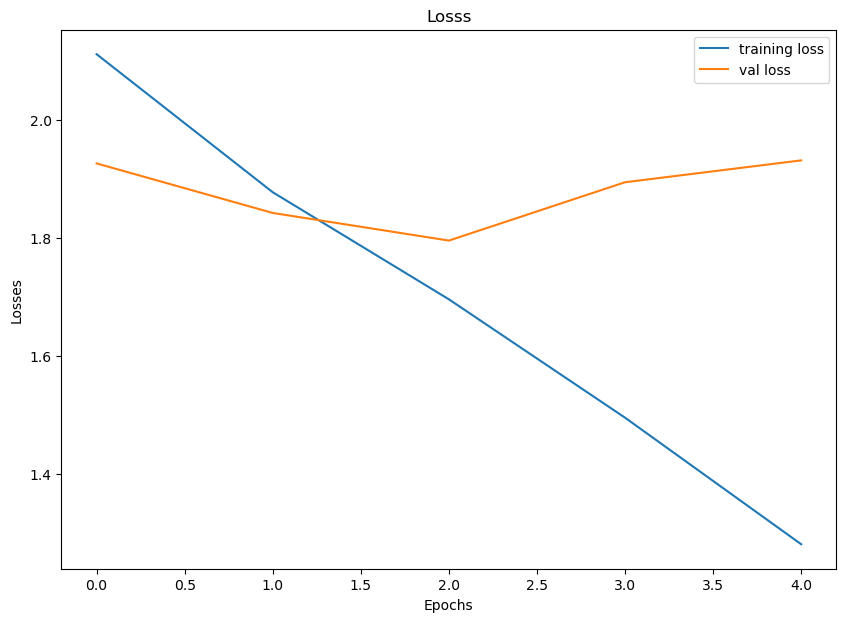

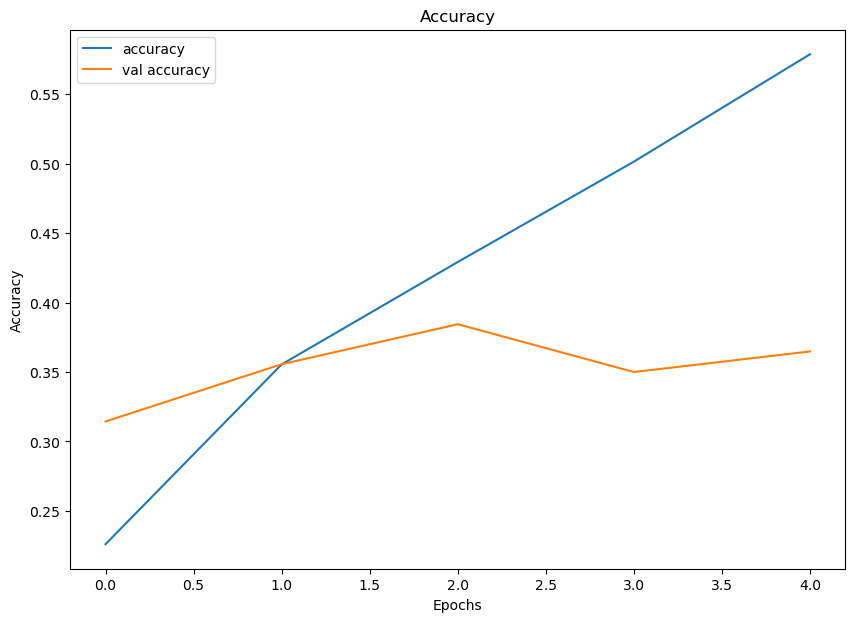

In [13]:
plot_loss(history_1)

> 🤔 Humm... It seems like our model `overfitting`. What can we do next? 

### 6. Adjust the model hyperparameters (to beat hte baseline/reduce overfitting)

Let's try fix overfitting by...

* **Get more data**
* **Simple the model**
* **Use data augmentation**
* **Use transfer learning**

#### Removing 2 convolution layers.

In [15]:
# Set seed
tf.random.set_seed(42)

# Build a model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax") # 10 outputs. Hence, we use 10 here instead.
])

# Compile a model
model_2.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"]
)

# Fit the model
history_2 = model_2.fit(train_data,
                        steps_per_epoch=len(train_data),
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5


2024-02-01 23:00:15.224636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


235/235 [==============================] - ETA: 0s - loss: 2.1190 - accuracy: 0.2487

2024-02-01 23:00:39.412361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


235/235 [==============================] - 30s 126ms/step - loss: 2.1190 - accuracy: 0.2487 - val_loss: 1.9196 - val_accuracy: 0.3396
Epoch 2/5
235/235 [==============================] - 29s 123ms/step - loss: 1.7689 - accuracy: 0.4008 - val_loss: 1.9312 - val_accuracy: 0.3208
Epoch 3/5
235/235 [==============================] - 29s 122ms/step - loss: 1.4418 - accuracy: 0.5255 - val_loss: 1.8614 - val_accuracy: 0.3616
Epoch 4/5
235/235 [==============================] - 29s 123ms/step - loss: 0.9542 - accuracy: 0.7036 - val_loss: 2.0788 - val_accuracy: 0.3384
Epoch 5/5
235/235 [==============================] - 29s 123ms/step - loss: 0.5219 - accuracy: 0.8532 - val_loss: 2.5131 - val_accuracy: 0.3296


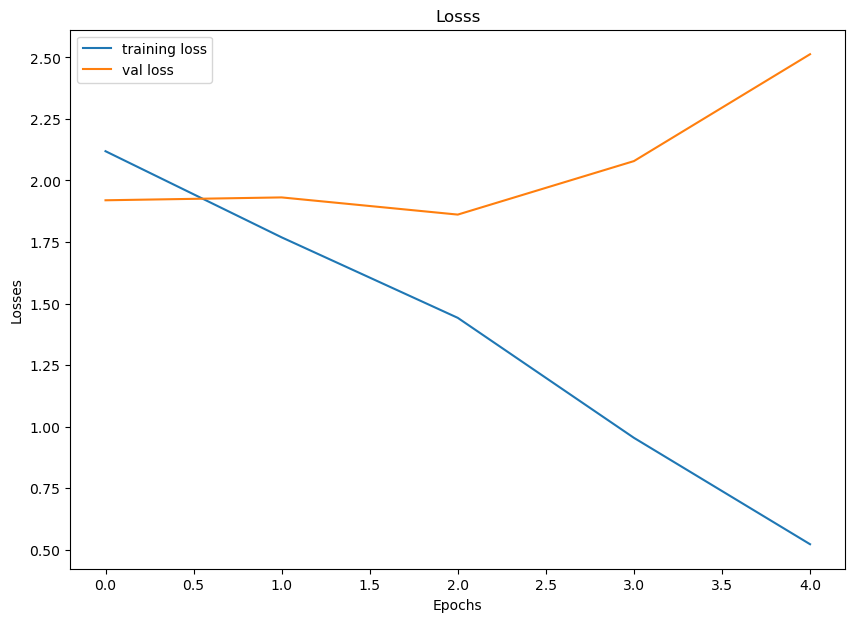

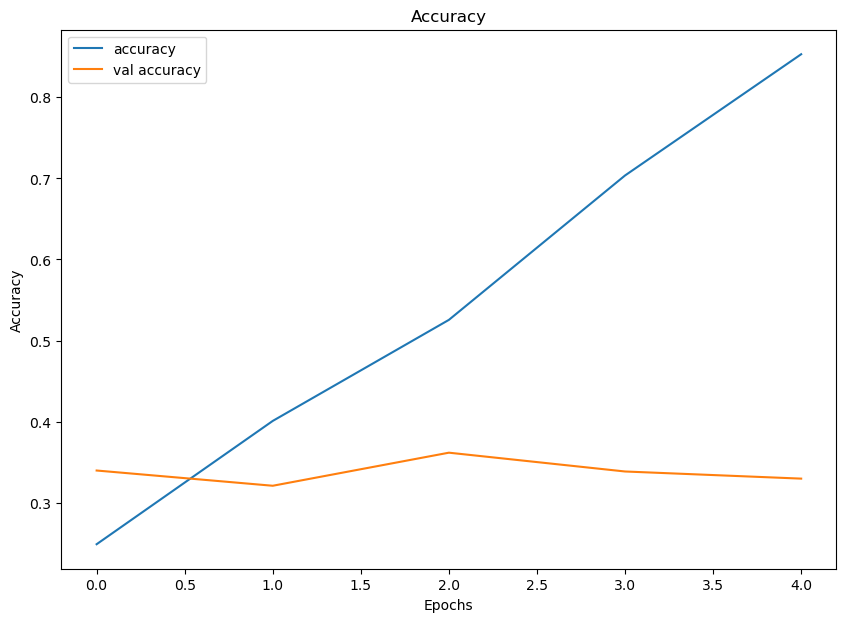

In [16]:
plot_loss(history_2)

> Seems like simple our model did not work 😅 How about we try data agumetation.

#### Data augmentation

In [29]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augemntation = ImageDataGenerator(rescale=1/225.,
                                rotation_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)

In [30]:
train_data_augmented = train_datagen_augemntation.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   shuffle=True) # Don't shuffle as False

Found 7500 images belonging to 10 classes.


In [37]:
# Let's create another model but this time we'll fit it on augmented training data
model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax") # 10 outputs. Hence, we use 10 here instead.
])

# Compile the model
model_3.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"]
)


In [38]:
# Fit the model
history_3 = model_3.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5


2024-02-01 23:16:53.948682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


235/235 [==============================] - ETA: 0s - loss: 2.1466 - accuracy: 0.2213

2024-02-01 23:17:43.680264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


235/235 [==============================] - 55s 235ms/step - loss: 2.1466 - accuracy: 0.2213 - val_loss: 1.9922 - val_accuracy: 0.2740
Epoch 2/5
235/235 [==============================] - 56s 239ms/step - loss: 1.9625 - accuracy: 0.3116 - val_loss: 1.9542 - val_accuracy: 0.3256
Epoch 3/5
235/235 [==============================] - 55s 232ms/step - loss: 1.8736 - accuracy: 0.3635 - val_loss: 1.8813 - val_accuracy: 0.3472
Epoch 4/5
235/235 [==============================] - 55s 236ms/step - loss: 1.8277 - accuracy: 0.3737 - val_loss: 1.8409 - val_accuracy: 0.3780
Epoch 5/5
235/235 [==============================] - 55s 234ms/step - loss: 1.7855 - accuracy: 0.3919 - val_loss: 1.8148 - val_accuracy: 0.3708


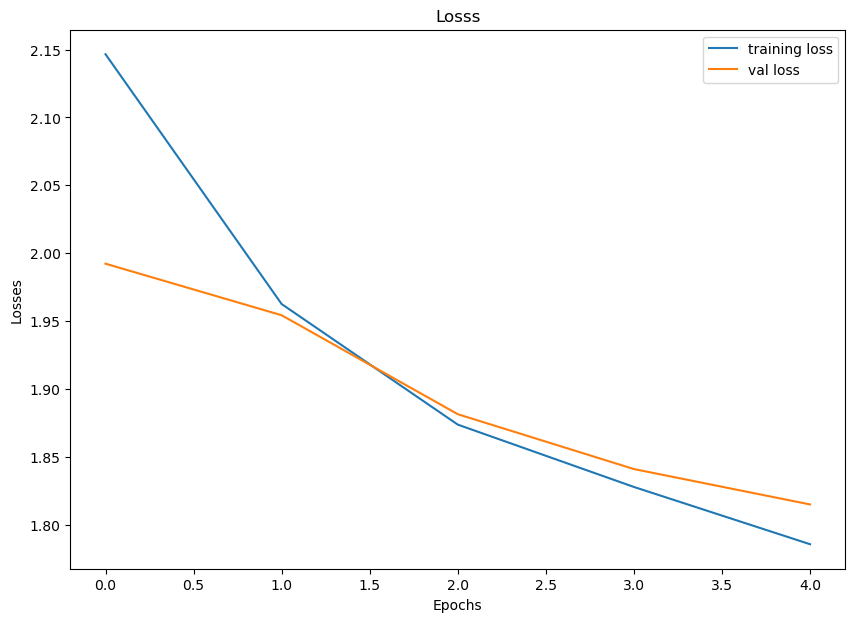

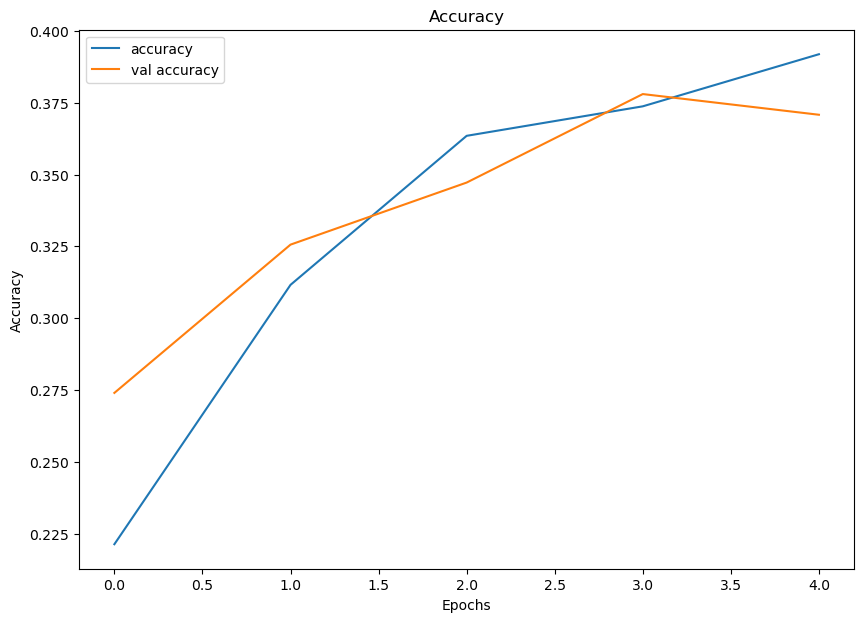

In [39]:
plot_loss(history_3)

### 7. Repeat until satisfied

We could keep goining here... continually tryingto bring our loss curves closer together and trying to improve the validation/test accuracy.

How? 🤔

By running los of experiments, namely: 🧠
- Restructuring our model's architecture (increase layers in the hidden unit)
- Adjust learning rate
- Try different methods of data agumentation (adjust the hyperparameters in our ImageDataGenerator)
- Try training for longer (e.g 10 epochs)
- Try **transfer learning** 

### Makeing a prediction with our training model

Let's use our train model to make some predictions on our custom images!

In [51]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

1/1 [==============================] - 0s 13ms/step


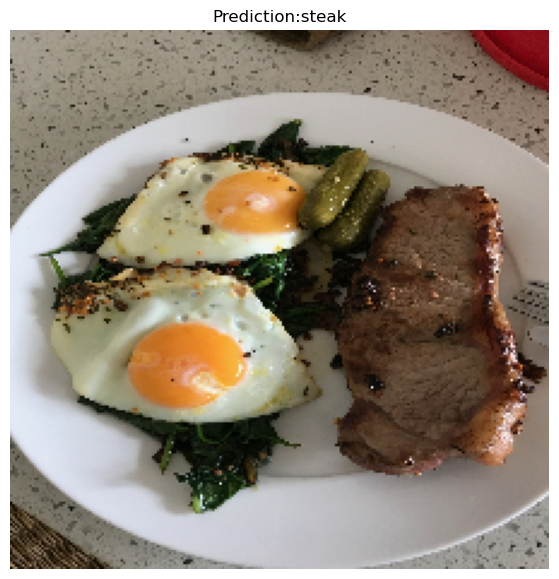

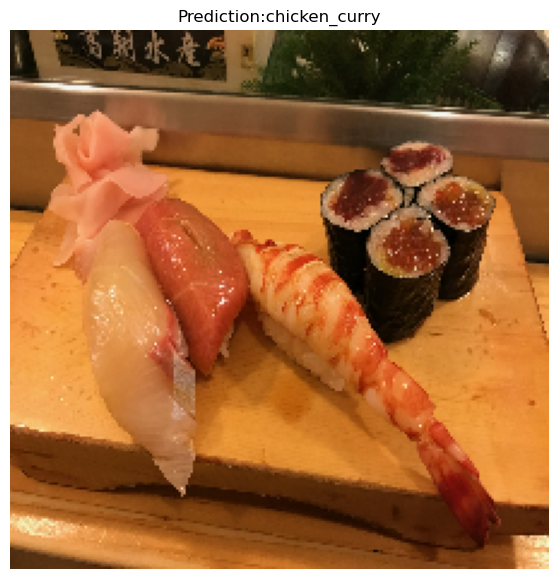

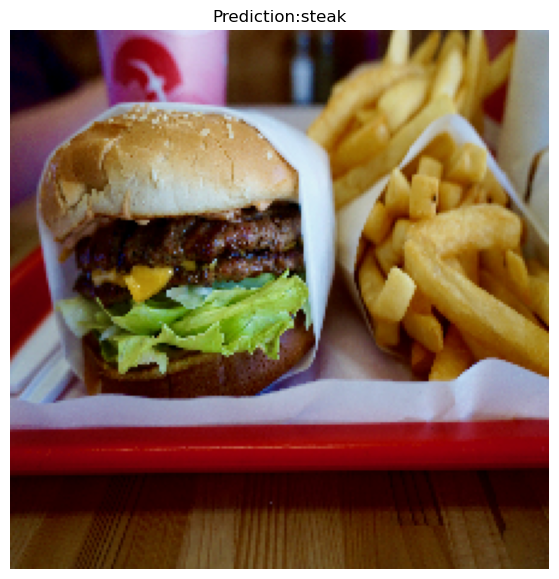

In [54]:
pred_and_plot(model_3, "03-steak.jpeg", class_names)
pred_and_plot(model_3, "03-sushi.jpeg", class_names)
pred_and_plot(model_3, "03-hamburger.jpeg", class_names)

> Poor prediction 🌇